In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, random
import math

### Data Visualization

In [2]:
class Data_Visualization:
    def __init__(self, dirpath=r'MNIST\Samples', no_imgs_in_row=5, no_imgs_in_col=5):
        self.dirpath=dirpath
        self.no_imgs_in_row=no_imgs_in_row
        self.no_imgs_in_col=no_imgs_in_col
    def fetch_random_img(self):
        files = os.listdir(self.dirpath)
        idx=random.randrange(0, len(files))
        img=np.array(Image.open(os.path.join(self.dirpath, files[idx])))
        return img
    
    def show_random_images(self):
        fig,axs=plt.subplots(self.no_imgs_in_row,self.no_imgs_in_col)
        for i in range(self.no_imgs_in_row):
            for j in range(self.no_imgs_in_col):
                axs[i,j].imshow((self.fetch_random_img()))
        

### Test Data Visualization

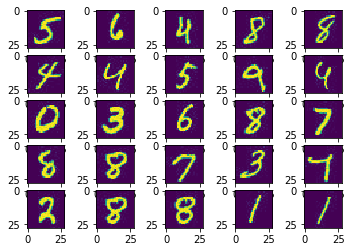

In [3]:
d_v=Data_Visualization()
d_v.show_random_images()

### Load Data

In [4]:
class Load_data:
    def __init__(self,dirpath=r'MNIST\Samples',tr_percentage=0.7):
        self.dirpath=dirpath
        self.tr_percentage=tr_percentage
    def make_tr_and_te_ds(self):
        files = os.listdir(self.dirpath)
        no_img_in_tr=int(np.floor(self.tr_percentage*len(files)))
        tr=[]
        te=[]
        idx=np.random.randint(len(files), size=(len(files)))
        tr_idx=idx[0:no_img_in_tr]
        te_idx=idx[no_img_in_tr:len(idx)]
   
        tr.append([np.array(Image.open(os.path.join(self.dirpath, files[tr_idx[i]]))) for i in range(len(tr_idx))])
        te.append([np.array(Image.open(os.path.join(self.dirpath, files[te_idx[j]]))) for j in range(len(te_idx))])

        tr=np.expand_dims(tr[0], axis=3) # add the dimension related to number of channels
        te=np.expand_dims(te[0], axis=3) # add the dimension related to number of channels
        return tr,te            
        

### Test Load Data

In [5]:
Load_d=Load_data()
tr,te=Load_d.make_tr_and_te_ds()
        
print(tr.shape)
print(te.shape)

(420, 28, 28, 1)
(180, 28, 28, 1)


### Convolution Layer

In [23]:
class Conv_Layer:
    
    def __init__(self, filter,b,p,s,activation_func='RELU'):
        
        '''filter is the kernel used to convolve X. filter has a dimension of n_f*f_w*f_h*f_c 
        where n_f,f_w,f_h and f_c are number of filters,width, height and number of channels for each filter. 
        Please note that f_c would be equal to X_c.

        b is the bias which is a vector of dimension 1*f_c. It means that we will have one bias for each filter
        P is the pad size of dimension (p_w,p_h).
        s is the stride.
        activation_func could be 'RELU' or 'NONE'. '''
        
        self.filter = filter
        self.b = b
        self.p = p
        self.s = s
        self.activation_func  = activation_func
        
    def RELU(self,a):
        return max(a,0)
    
    def pad_img(self,X):
        """
        X is a batch of n images each with w*h*c dimension 
        where w,h and c are width,height and number of channels of each input image
        """ 
        X_paded=np.pad(X,mode='constant',constant_values=(0,0),pad_width=((0,0),(self.p[0],self.p[0]),(self.p[1],self.p[1]),(0,0)))
        return X_paded

    def conv(self,X):
        """
        X is a batch of n images each with X_w*X_h*X_c dimension 
        where X_w,X_h and X_c are width,height and number of channels of each input image.

        The dimension of convolved X  (i.e., the output of this function) would be:
        n*( (X_w - f_w + 2p)/s + 1 )*( (X_h - f_h + 2p)/s + 1 )*n_f
        """
        no_imgs=int(X.shape[0])
        n_f=int(self.filter.shape[0])
        padded_X=self.pad_img(X)
        print ("padded_X.shape=",padded_X.shape)
        f_w=int(self.filter.shape[1]) # width of filter
        f_h=int(self.filter.shape[2]) #height of filter

        O_w=int((padded_X.shape[1]-f_w+2*self.p[0])/self.s +1) # width of output
        O_h=int((padded_X.shape[2]-f_h+2*self.p[1])/self.s +1) #height of output


        convolved_X=np.zeros(shape=(no_imgs,O_w,O_h,n_f))

        for k in range(no_imgs): # for each image in the batch
            for f in range(n_f): # for each filter
                # calculate each cell of the convolved X
                for j in range(O_h):
                    for i in range(O_w):
                        start_w=i*self.s #  identify the left corner start point of the current sliding window 
                        start_h=j*self.s #  identify the left corner start point of the current sliding window 
                        curr_input_slice=padded_X[k,start_w:start_w+f_w,start_h:start_h+f_h,:]
                        curr_filter=self.filter[f,:,:,:]
                        a=curr_input_slice*curr_filter
                        if self.activation_func=='RELU':
                            convolved_X[k,i,j,f]=self.RELU(np.sum(a)+self.b[f])
                        elif self.activation_func=='NONE':
                            convolved_X[k,i,j,f]=np.sum(a)+self.b[f]

        return convolved_X,X # X is returned because we will need them in back propagation process (i.e.,to calculate derivative of cost function w.r.t X )
    
    def backward_pass(self,d_out,X):
        """
        d_out is the derivative of cost function wih respect to the output of current layer. Please note that 
        the output of current layer is the input of next layer. As a result, we could calculate d_out of each layer by 
        obtaining the derivative of cost function w.r.t the input of next layer.

        X is the input of the current layer
        s is the stride used for current layer
        p is is the padding used for current layer
        filter is the filter used for current layer

        This function returns:

        d_w which stands for the derivative of cost function w.r.t w parameters (i.e., each cell of each filter used 
        in current layer). d_w would be of shape n_f*f_w*f_h*f_c where n_f,f_w,f_h and f_c are number of filters,width,
        height and number of channels for each filter.

        d_b  which stands for the derivative of cost function w.r.t bias of each filter used in the current layer. d_b 
        would be of shape 1*f_c

        d_X  which stands for the derivative of cost function w.r.t input of this layer which will be used as the d_out of
        previous layer. d_X would be of shape n*w*h*c
        """

        d_w=np.zeros(shape=self.filter.shape)
        d_b=np.zeros(shape=(1,self.filter.shape[0]))
        d_x=np.zeros(shape=X.shape)
        
        padded_X=self.pad_img(X)
        padded_d_x=self.pad_img(d_x)
        
        
        no_imgs=int(X.shape[0])
        n_f=int(self.filter.shape[0])
        f_w=int(self.filter.shape[1]) # width of filter
        f_h=int(self.filter.shape[2]) #height of filter
        O_w=int((padded_X.shape[1]-f_w+2*self.p[0])/self.s +1) # width of output
        O_h=int((padded_X.shape[2]-f_h+2*self.p[1])/self.s +1) #height of output
        
        for k in range(no_imgs): # for each image in the batch
            for f in range(n_f): # for each filter
                # calculate each cell of the convolved X
                for j in range(O_h):
                    for i in range(O_w):
                        start_w=i*self.s #  identify the left corner start point of the current sliding window 
                        start_h=j*self.s #  identify the left corner start point of the current sliding window 
                        curr_input_slice=padded_X[k,start_w:start_w+f_w,start_h:start_h+f_h,:]

                        # Update gradients 
                        print("d_out[k, j, i, f]",d_out[k, j, i, f])
                        print("self.filter[f,:,:,:].shape",self.filter[f,:,:,:].shape)
                        print("padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:]",padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:].shape)
                        
                        d_w[f,:,:,:] += curr_input_slice * d_out[k, j, i, f]
                        d_b[0,f] += d_out[k, j, i, f]
                        #padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] += self.filter[f,:,:,:] * d_out[k, j, i, f]

        return d_w,d_b
    #,padded_d_x
    

### Test Convolution Layer - forward pass


In [24]:
X=np.random.randint(5,size=(10,5,5,3))
filter=np.random.randint(5,size=(6,2,2,3))
bias=np.random.randint(100,size=(6))
print("bias=",bias)
conv_layer_1=Conv_Layer(filter=filter,b=bias,p=(1,1),s=2,activation_func='RELU')
conv_X,X=conv_layer_1.conv(X)
print ("X.shape=",X.shape,"filter.shape=",filter.shape,"conve_X.shape=",conv_X.shape)


bias= [37 10 32 84 39 15]
padded_X.shape= (10, 7, 7, 3)
X.shape= (10, 5, 5, 3) filter.shape= (6, 2, 2, 3) conve_X.shape= (10, 4, 4, 6)


### Test Convolution Layer - backward pass

In [25]:
X=np.random.randint(5,size=(10,5,5,3))
filter=np.random.randint(5,size=(6,2,2,3))
bias=np.random.randint(100,size=(6))
print("bias=",bias)
conv_layer_1=Conv_Layer(filter=filter,b=bias,p=(1,1),s=2,activation_func='RELU')
conv_X,X=conv_layer_1.conv(X)
print ("X.shape=",X.shape,"filter.shape=",filter.shape,"conve_X.shape=",conv_X.shape)

d_out=np.random.randint(5,size=(10,4,4,6))
d_w,d_b=conv_layer_1.backward_pass(d_out,X)
print("d_w.shape=",d_w.shape,"d_b.shape=",d_b.shape)


bias= [87 74 88 93  9 55]
padded_X.shape= (10, 7, 7, 3)
X.shape= (10, 5, 5, 3) filter.shape= (6, 2, 2, 3) conve_X.shape= (10, 4, 4, 6)
d_out[k, j, i, f] 3
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 3
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 4
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 3
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_ou

d_out[k, j, i, f] 0
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 2, 3)
d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 1, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 1, 3)
d_out[k, j, i, f] 4
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 1, 3)
d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 1, 3)
d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f

d_out[k, j, i, f] 3
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 4
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 2, 3)
d_out[k, j, i, f] 4
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 4
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 0
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 1, 3)
d_out[k, j, i, f

d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 1, 3)
d_out[k, j, i, f] 0
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 1
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 2
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (1, 2, 3)
d_out[k, j, i, f] 4
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 0
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f] 0
self.filter[f,:,:,:].shape (2, 2, 3)
padded_d_x[k,start_w:start_w+f_w,start_h:start_h+f_h,:] (2, 2, 3)
d_out[k, j, i, f

### Pool Layer

In [19]:
class Pool_Layer:
    def __init__(self,pool_size=(2,2),pool_type='MAX',s=1):
        '''
        Pool_size defines the window size from which we are going to get the average or max. 
        Pool_size has a dimension of p_w*p_h where
        p_w and p_h are width and height of the pooling window.
        s is stride
        pool_type will accept values 'MAX' and 'AVG'
        '''
        self.pool_size = pool_size
        self.pool_type = pool_type
        self.s = s
    
    def pool(self,X):
        """
        X is a batch of convoluted images with a dimension of n_x,w_x,h_x,c_x
        
        """
        O_w=int((X.shape[1]-self.pool_size[0])/self.s +1) # width of output
        O_h=int((X.shape[2]-self.pool_size[1])/self.s +1) #height of output
        n_x=int(X.shape[0])
        c_x=int(X.shape[3])
        pooled_X=np.zeros(shape=(n_x,O_w,O_h,c_x))

        for k in range(n_x): # for each image in the batch
            for c in range(c_x): # for each channel
                # calculate each cell of the pooled X
                for j in range(O_h):
                    for i in range(O_w):
                        start_w=i*self.s #  identify the left corner start point of the current sliding window 
                        start_h=j*self.s #  identify the left corner start point of the current sliding window 
                        curr_input_slice=X[k,start_w:start_w+self.pool_size[0],start_h:start_h+self.pool_size[1],c]
                        if (self.pool_type=='MAX'):
                            pooled_X[k,i,j,c]=np.max(curr_input_slice)
                        elif (self.pool_type=='AVG'):
                            pooled_X[k,i,j,c]=np.average(curr_input_slice)
        return pooled_X,X
    
    def backward_pass(self,d_out,X):
        '''
        This function returns:
        d_X  which stands for the derivative of cost function w.r.t input of this layer, same shape as X
        '''
        O_w=int((X.shape[1]-self.pool_size[0])/self.s +1) # width of output
        O_h=int((X.shape[2]-self.pool_size[1])/self.s +1) #height of output
        n_x=int(X.shape[0])
        c_x=int(X.shape[3])
        pooled_X=np.zeros(shape=(n_x,O_w,O_h,c_x))
        d_X=np.zeros(shape=X.shape)
        for k in range(n_x): # for each image in the batch
            for c in range(c_x): # for each channel
                # calculate each cell of the pooled X
                for j in range(O_h):
                    for i in range(O_w):
                        start_w=i*self.s #  identify the left corner start point of the current sliding window 
                        start_h=j*self.s #  identify the left corner start point of the current sliding window 
                        curr_input_slice=X[k,start_w:start_w+self.pool_size[0],start_h:start_h+self.pool_size[1],c]
                        if (self.pool_type=='MAX'):
                            max_mask = np.array((curr_input_slice == np.max(curr_input_slice)))
                            d_X[k,start_w:start_w+self.pool_size[0],start_h:start_h+self.pool_size[1],c]=curr_input_slice+(max_mask*d_out[k,i,j,c])
                        elif (self.pool_type=='AVG'):
                            # the gradients should be equally distributed
                            avg_d_out=np.average(d_out[k,start_w:start_w+self.pool_size[0],start_h:start_h+self.pool_size[1],c])
                            avg_matrix=np.ones(shape=curr_input_slice.shape)
                            d_X[k,start_w:start_w+self.pool_size[0],start_h:start_h+self.pool_size[1],c]=curr_input_slice+avg_matrix
                            
                            
        return d_X

        


### Test Pool Layer - forward pass

In [20]:
X=np.random.randint(1000,size=(10,25,25,3))
pool_layer_1=Pool_Layer(pool_size=(10,10),pool_type='MAX',s=3)
pooled_X,X=pool_layer_1.pool(X)
print ("X.shape=",X.shape,"pooled_X.shape=",pooled_X.shape)

X.shape= (10, 25, 25, 3) pooled_X.shape= (10, 6, 6, 3)


### Test Pool Layer - backward pass (Max Pooling)

In [21]:
X=np.random.randint(1000,size=(10,25,25,3))
pool_layer_1=Pool_Layer(pool_size=(10,10),pool_type='MAX',s=3)
pooled_X,X=pool_layer_1.pool(X)
print ("X.shape=",X.shape,"pooled_X.shape=",pooled_X.shape)
d_out=np.random.randint(1000,size=(10,6,6,3))
d_x=pool_layer_1.backward_pass(d_out,X)
print ("d_x.shape=",d_x.shape)

X.shape= (10, 25, 25, 3) pooled_X.shape= (10, 6, 6, 3)
d_x.shape= (10, 25, 25, 3)


### Test Pool Layer - backward pass (Average Pooling)

In [22]:
X=np.random.randint(1000,size=(10,25,25,3))
pool_layer_1=Pool_Layer(pool_size=(10,10),pool_type='AVG',s=3)
pooled_X,X=pool_layer_1.pool(X)
print ("X.shape=",X.shape,"pooled_X.shape=",pooled_X.shape)
d_out_2=np.random.randint(1000,size=(10,6,6,3))
d_x=pool_layer_1.backward_pass(d_out_2,X)
print ("d_x.shape=",d_x.shape)


X.shape= (10, 25, 25, 3) pooled_X.shape= (10, 6, 6, 3)
d_x.shape= (10, 25, 25, 3)


c:\users\ehajimani\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\ehajimani\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Fully Connected Layer

In [89]:
class FC_Layer:
    def __init__(self,no_of_fully_connected_nodes=10, activation_func='RELU'):
        self.no_of_fully_connected_nodes=no_of_fully_connected_nodes
        self.p = (0,0)
        self.s = 1
        self.activation_func=activation_func
        self.bias=np.random.rand(self.no_of_fully_connected_nodes)
        
    def add_layer (self,X):
        """
        X is the input to the fully connected layer with a dimension of n_X*w_X*h_X*c_X
        where n_X, w_X, h_X and c_X are number of convolved images in the batch, width of each convolved image, height of 
        each convolved image and number of channels, respectively.
        The fully connected layer  would be of shape: n_X* no_of_fully_connected_nodes. 
        To do this conversion we would need "no_of_fully_connected_nodes" filters of dimension w_X*h_X*c_X
        """
        w_X=int(X.shape[1])
        h_X=int(X.shape[2])
        c_X=int(X.shape[3])
        self.filter=np.random.rand(self.no_of_fully_connected_nodes,w_X,h_X,c_X)
        print ("filter.shape=",self.filter.shape)
        fc_conv_layer=Conv_Layer(filter=self.filter,b=self.bias,p=self.p,s=self.s,activation_func=self.activation_func)
        FC,X=fc_conv_layer.conv(X)


        return FC
        

### Test Fully Connected Layer

In [90]:
X=np.random.randint(1000,size=(10,25,25,100))
fc_layer_1=FC_Layer(no_of_fully_connected_nodes=10,activation_func='RELU')
fc1=fc_layer_1.add_layer(X) # should give us the output of shape (no_images=10, 1, 1, no_fully_connected_nodes=10)

fc_layer_2=FC_Layer(no_of_fully_connected_nodes=3,activation_func='RELU')
fc2=fc_layer_2.add_layer(fc1) # should give us the output of shape (no_images=10, 1, 1, no_fully_connected_nodes=3)


print("fc1.shape=",fc1.shape)
print("fc2.shape=",fc2.shape)

filter.shape= (10, 25, 25, 100)
padded_X.shape= (10, 25, 25, 100)
filter.shape= (3, 1, 1, 10)
padded_X.shape= (10, 1, 1, 10)
fc1.shape= (10, 1, 1, 10)
fc2.shape= (10, 1, 1, 3)


### Softmax Layer

In [91]:
class Softmax_Layer:
    def __init__(self):
        pass
    def add_layer (self,X):
        return np.exp(X)/np.sum(np.exp(X))

### Test Softmax Layer

In [92]:
fc=np.random.rand(10)
print ("fc=",fc)
softmax=Softmax_Layer()
sf=softmax.add_layer(fc)
print("softmax(fc)=",sf)

fc= [0.33382165 0.24050942 0.79789493 0.11962923 0.50881666 0.66792316
 0.9820767  0.66288912 0.04490436 0.115886  ]
softmax(fc)= [0.08509414 0.07751302 0.13534559 0.0686874  0.10136756 0.1188497
 0.16271711 0.11825291 0.06374182 0.06843076]


### Optimization 

In [93]:
class Optimization:
    def __init__(self):
        pass
    def Loss(self,actual_v,estimated_v):
        return -1*(actual_v*np.log(estimated_v)+(1-actual_v)*np.log(1-estimated_v))
    def Cost(self,actual_v,estimated_v):
        return np.average(self.Loss(actual_v,estimated_v))